In [15]:
import cv2
from datetime import datetime
import ipywidgets
from IPython.display import display
from matplotlib import pyplot as plt
import os
from motor_control import MotorControl
from picamera2 import Picamera2, Preview
import requests
import time

__Important__: only run this notebook after you have trained the model and started the prediction server. Please refer to the README for instructions on how to do this.

You will notice that much of this notebook is the same as the previous one. The main difference is that we will be using the model to predict the class of the brick and then sorting it accordingly instead of just dumping everything in a single bucket.

Ideally there would be some code reuse going on here. 

In [2]:
# Start the camera as we have explained in `01_testing_the_camera` notebook
picam2 = Picamera2()
# using the default configuration for now
camera_config = picam2.create_preview_configuration()
picam2.configure(camera_config)
# Start the preview and camera
picam2.start_preview(Preview.NULL)
picam2.start()
time.sleep(2)

[0:41:50.565126783] [1502]  INFO Camera camera_manager.cpp:284 libcamera v0.2.0+46-075b54d5
[0:41:50.672644551] [1524]  WARN RPiSdn sdn.cpp:39 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[0:41:50.678195201] [1524]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/imx477@1a to Unicam device /dev/media0 and ISP device /dev/media2
[0:41:50.678314885] [1524]  INFO RPI pipeline_base.cpp:1144 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[0:41:50.686239456] [1502]  INFO Camera camera_manager.cpp:284 libcamera v0.2.0+46-075b54d5
[0:41:50.761719573] [1527]  WARN RPiSdn sdn.cpp:39 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[0:41:50.766990836] [1527]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/imx477@1a to Unicam device /dev/media0 and ISP device /dev/media2
[0:41:50.767104706] [1527]  INFO RPI pipeline_base.cpp:1144 Using configuration file '/usr/share/libcamera/pipeline/r

In [3]:
# Connect to the motor, see the previous notebook for more details
motor_control = MotorControl()

In [4]:
def take_picture():
    return picam2.capture_array("main")
def bytes_to_jpg(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return bytes(cv2.imencode('.jpg', img_rgb)[1])

In [5]:
# I changed this to make sure my new pictures are more in line with the older ones.
# Probably the upgrade from rpicam to picam2 changed the default exposure value.
# If this is the first time taking pictures, there is not much point in setting this or any other control setting.
# For reference, all settings can be found in the appendix of the official picamera documentation: https://datasheets.raspberrypi.com/camera/picamera2-manual.pdf 
picam2.set_controls({"ExposureValue": 1})

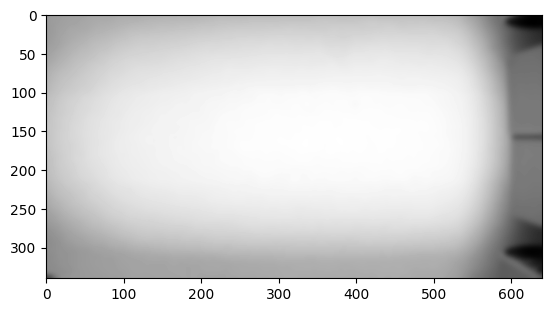

In [7]:
top_border = 100
bottom_border = 40
    
def pre_process_image(image):
    without_borders = image[top_border:480-bottom_border,:]
    gray = cv2.cvtColor(without_borders, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (21, 21), 0)
    return gray

# We take an initial picture with no bricks on the belt. This will be our reference image so we can detect when a brick is on the belt.
# Make sure there are no bricks on the camera belt when you run this cell.
first_picture = take_picture()
first_image = pre_process_image(first_picture)
plt.imshow(first_image, cmap='gray')

In [8]:
# This function takes a picture and compares is against the reference image.
# If a change is detected (a brick is on the belt), it will return the x coordinate of the leftmost contour.

def update_image(image_widget: ipywidgets.Image = None, processed_widget: ipywidgets.Image = None):
    cam_img = take_picture()
    if image_widget:
        image_widget.value = bytes_to_jpg(cam_img)
    gray = pre_process_image(cam_img)
    
    image_diff = cv2.absdiff(first_image, gray)
    thresh = cv2.threshold(image_diff, 50, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.dilate(thresh, None, iterations=2)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    left_most_contour_x = 640
    for c in contours:
        # if the contour is too small, ignore it
        if cv2.contourArea(c) < 40:
            continue
        # compute the bounding box for the contour, draw it on the frame,
        # and update the text
        (x, y, w, h) = cv2.boundingRect(c)
        if w > 600 or w < 50:
            continue
        cv2.rectangle(cam_img, (x, y + top_border), (x + w, y + h + top_border), (0, 255, 0), 2)
        if x < left_most_contour_x:
            left_most_contour_x = x 

    image_widget.value = bytes_to_jpg(cam_img)
    if processed_widget:
        processed_widget.value = bytes_to_jpg(thresh)
    return left_most_contour_x

In [16]:
def write_image(image_bytes, prefix = ''):
    filename = os.path.join('/tmp', prefix + datetime.now().strftime("%Y%m%d%H%M%S") + ".jpg")
    with open(filename, "wb") as file:
       file.write(image_bytes)
    return filename

In [52]:
# You will need to update this url to match your computer's IP address. You can find it by running `ipconfig` in PowerShell.
predict_url = "http://192.168.0.250:8000/predict"
def predict(image_bytes):
    filepath = write_image(bytes_to_jpg(image_bytes))
    filename = filepath[filepath.rindex('/')+1:]
    with open(filepath, 'rb') as file:
        files={
            'image': (filename,file,'image/jpeg')
        }
        headers = {
            'Accept': 'application/json',
        }
        return requests.request("POST", predict_url, headers=headers, files=files).json()

In [53]:
# Testing it out, the returned result is, of course, garbage, because we are sending an empty image.
predict(take_picture())

{'prediction': '43857liftarmthick1x2', 'confidence': 0.45013415813446045}

In [9]:
# These widgets will show what is happening in the machine. The left one will show the camera feed, and the right one will show the processed image that
# is used to detect the bricks.
# To test, manually put a brick on the belt. If you took the reference image correctly, you should see a rectangle around the brick.
image_widget = ipywidgets.Image(format='jpeg')
processed_widget = ipywidgets.Image(format='jpeg')

display(ipywidgets.HBox([image_widget, processed_widget]))

update_image(image_widget, processed_widget)

640

In [54]:
bucket_mapping = {
    "15712tile1x1withopenoclip": 0,
    "3023plate1x2": 1,
    "43857liftarmthick1x2": 2
}
default_bucket = 3

In [59]:
import threading
from time import sleep
running = True
def update_image_loop():
    global running
    motor_control.on_all()
    while running:
        contour_x = update_image(image_widget, processed_widget)
        if  contour_x < 640:
            motor_control.stop_all()
            sleep(0.5) # wait for brick to drop
            contour_x = update_image(image_widget, processed_widget)
            motor_control.move_to_center(contour_x)
            sleep(3) # wait for brick to be in the center
            prediction = predict(take_picture())
            print(prediction)
            predicted_confidence = prediction["confidence"]
            predicted_brick_type = prediction["prediction"]
            if predicted_brick_type in bucket_mapping and predicted_confidence > 0.85:
                motor_control.move_turntable(bucket_mapping[predicted_brick_type])
            else:
                motor_control.move_turntable(default_bucket)
            sleep(6) 
            # note that we need to wait quite long here, because we don't know how long it will take for
            # the buckets to rotate. A big improvement can be made if the ev3 would call back when it has finished
            # its operations.
            motor_control.clear_camera_belt()
            sleep(6) # wait for belt to clear
            motor_control.on_all()
    motor_control.stop_all()
        
t = threading.Thread(target=update_image_loop)
t.start()

In [60]:
# Stop the machine. This will stop the loop, but not release all resources, so you can restart the by simply running the cell above again.
running = False
t.join()

In [61]:
# Release all resources. This will fully stop everything. You will need to rerun most cells in this notebook to restart the machine.
picam2.stop()
picam2.stop_preview()
picam2.close()
motor_control.close()